### SARIMA

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from ipywidgets import IntProgress
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [4]:
plt.rcParams['figure.figsize'] = [10,8]

In [5]:
df = pd.read_csv('./data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [6]:
fig = px.line(df, x=df.date, y=df.data, width=800, height=400, color_discrete_sequence=['#fcba03'],
                 title='Quaterly EPS for J&J', labels= {'date': 'Year','data':'EPS($)'})
fig.show()

In [7]:
## Make data stationarity using Log difference
df['data_tr_1'] = np.log(df['data'])
df['data_tr_1'] = df['data_tr_1'].diff()

df.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


In [10]:
fig = px.line(df, x=df.date[1:], y=df.data_tr_1[1:], width=800, height=400, color_discrete_sequence=['#fcba03'],
                 title='Log Difference of Quaterly EPS for J&J', labels= {'date': 'Year','data_tr_1':'EPS($)'})
fig.show()

To reduce the variation in variance we would take the seasonal difference

In [12]:
# We see the difference in every quarter so the difference is 4, to apply the seasonality difference in the 4 quarters 
df['data_tr_2'] = df['data_tr_1'][1:].diff(4)
df.head(10)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


In [13]:
fig = px.line(df, x=df.date[1:], y=df.data_tr_2[1:], width=800, height=400, color_discrete_sequence=['#fcba03'],
                 title='Log Difference of Quaterly EPS for J&J(Seasonal Difference)', labels= {'date': 'Year','data_tr_1':'EPS($)'})
fig.show()

We could see the variance which is much more stable over the entire dataset

In [14]:
# Check the stationarity

ad_fuller_result = adfuller(df['data_tr_2'][5:])
print(f"ADF Statistics: {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF Statistics: -6.63080510991426
p-value: 5.721578695136251e-09


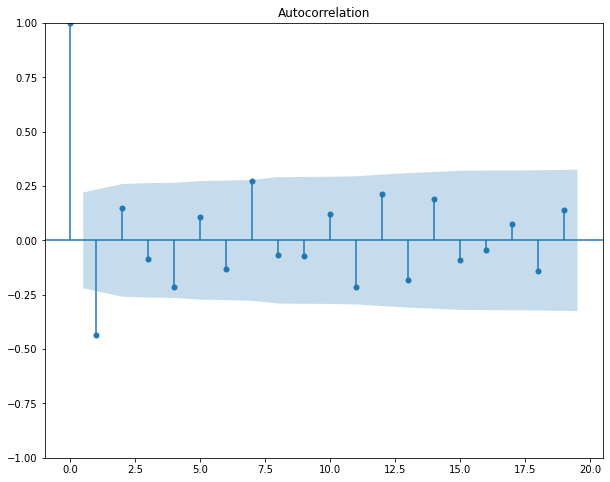

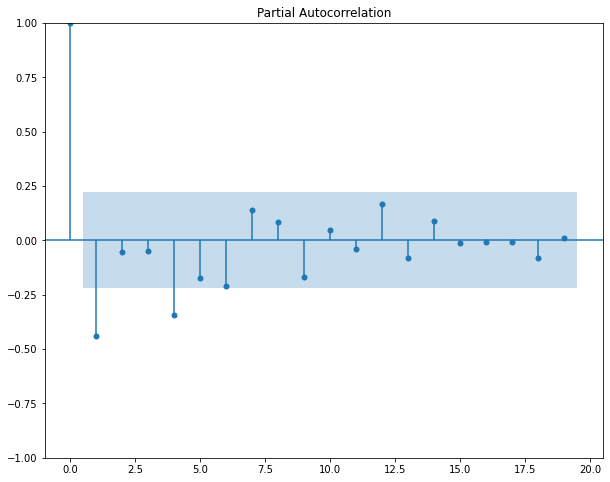

In [15]:
plot_acf(df['data_tr_2'][5:])
plot_pacf(df['data_tr_2'][5:])
plt.show()

+ P - Seasonal Autoregressive
+ Q - Seasonal moving average

In [16]:
def optimize_SARIMA(endog, parameter_list, d, D, s):
    """ Returns DF with parameters and corresponding AIC

        endog - the observed varaibles
        parameters_list - list with (p, q, P, Q) tuples
        d - Integration order
        D - Seasonal Integration order
        s - length of a season

    """

    results = []

    for param in tqdm_notebook(parameter_list):
        try:
            model = SARIMAX(endog,
                            order=(param[0], d, param[1]),
                            seasonal_order=(param[2], D, param[3], s),
                            simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append((param, aic))

    results_df = pd.DataFrame(results, columns=['parameters', 'aic'])
    results_df.columns = ['(p,q) x (P,Q)', 'AIC']
    results_df = results_df.sort_values('AIC', ascending=True).reset_index(drop=True)

    return results_df


In [17]:
p = range(0,4,1)
d =1
q = range(0,4,1)
P = range(0,4,1)
D = 1
Q = range(0,4,1)
s = 1

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [18]:
result_df = optimize_SARIMA(df['data'], parameters_list, 1, 1, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: 

,"(p,q) x (P,Q)",AIC
0,"(2, 3, 0, 0)",92.587233
1,"(2, 3, 1, 0)",93.981414
2,"(2, 3, 0, 1)",94.131180
3,"(3, 3, 0, 0)",94.468584
4,"(3, 2, 0, 3)",94.827060
...,...,...
251,"(0, 0, 3, 1)",144.211575
252,"(0, 0, 3, 3)",145.086240
253,"(0, 0, 2, 3)",145.465207
254,"(0, 0, 3, 2)",145.563923


In [19]:
best_model = SARIMAX(df['data'], order=(2,1,3), seasonal_order=(0,1,0,4), simple_differencing=False)
res = best_model.fit(disp=False)

print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.294
Date:                            Wed, 15 Jun 2022   AIC                             92.587
Time:                                    12:53:49   BIC                            106.804
Sample:                                         0   HQIC                            98.283
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4848      0.116    -12.797      0.000      -1.712      -1.257
ar.L2         -0.7900      0.131   

c:\Users\joshi\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



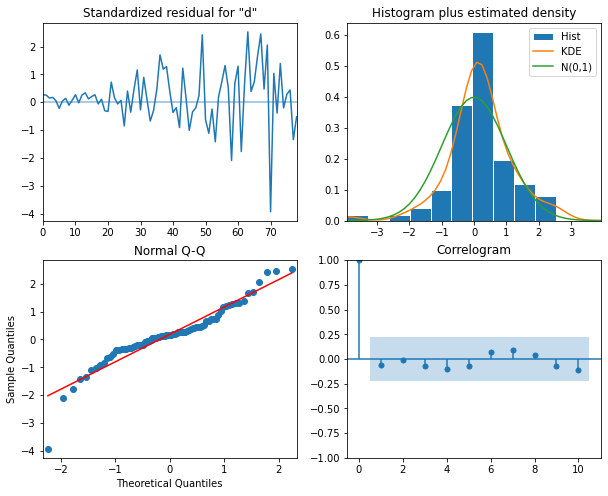

In [20]:
res.plot_diagnostics()
plt.show()

Correlogram is significant after lag 0, so the residuals are normal


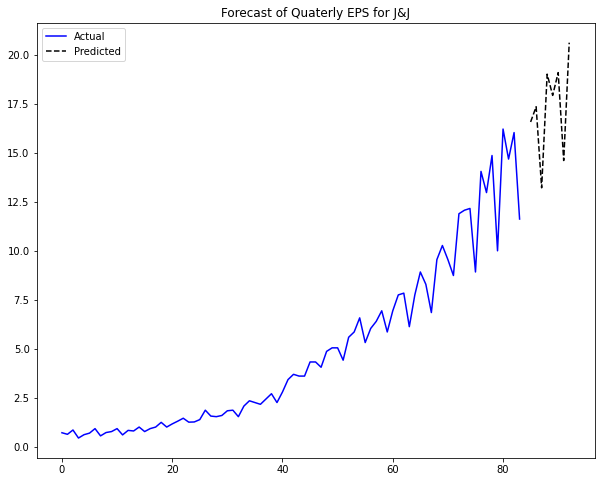

In [22]:
n_forecast = 8
predict = res.get_prediction(end = best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(df['data'], color='blue', label='Actual')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', label='Predicted')

ax.set_title("Forecast of Quaterly EPS for J&J")
plt.legend()
plt.show()

In [23]:
# Calculating mean_square error based on the predicted values

df['model'] = predict.predicted_mean
df.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.804931
7,1961-10-01,0.55,-0.514455,0.144006,0.482683
8,1962-01-01,0.72,0.269333,-0.057351,0.645230
9,1962-04-02,0.77,0.067139,-0.056093,0.748560


In [24]:
mse = mean_squared_error(df['data'], df['model'])

print(f"MSE: {mse}")

MSE: 0.15612109085094966


In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df["date"], y=df["data"], name="actual", mode="lines"))
fig.add_trace(go.Scatter(x=df["date"], y=df["model"], name="prediction", mode="lines"))
fig.update_layout(
    title="Quaterly EPS for J&J", xaxis_title="Year", yaxis_title="EPS($)"
)


fig.show()
